<p align="center">
    <!--If notebook is in folder notebooks change scr by "../images/logo.png"-->
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>06. Interpretación</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---


## 6.0 Introducción
La interpretabilidad es una parte fundamental de cualquier modelo de Machine Learning, de cara a poder poner en producción los modelos desarrollados. Existen fundamentalmente (y a muy grandes rasgos) dos clases de modelos de predicción, por lo menos en lo que a interpretabilidad se refiere:

* **Modelos lineales.** Tienen una interpretación más sencilla, pues los propios coeficientes indican tanto el peso como el signo, que indican cómo es el impacto de la variable. Además, también se realizan contrastes de significatividad, tanto a nivel individual como conjunto. 
* **Modelos no lineales.** Su interpretación es más compleja, pues requiere de unos cálculos adicionales a fin de determinar la importancia de cada variable en el modelo. 

Para la solución del caso planteado, se ha planteado un modelo **no lineal**, por lo que será necesario plantear una interpretación del mismo.

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 0.0.1 Estructura

0. Librerías y scripts
1. SHAP
    - Shapley Values
    - SHAP: basado en Shapley Values
2. Análisis
    - Modelo
    - Datos
    - Importancia de variables
    - Explicación de variables
    - SHAP: Importancia de variables
    - SHAP: Resumen

## Librerías

In [1]:
# IMPORTAR LIBRERÍAS
import shap 
import pickle
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

shap.initjs() # load JS visualization code to notebook

## 6.1 Medidas "clásicas"  de importancia de variables

A la hora de realizar una interpretabilidad de los modelos XGBoost, es de suma utilidad graficar las medidas incluidas en la propia librería de XGBoost. Estos gráficos tienen una serie de ventajas, en primer lugar, son muy sencillas y rápidas de calcular, y su interpretación es también bastante fácil de comprender. Se graficarán más adelante, con la función ".plot_importance".

Ahora bien, existen tres opciones de medidas de importancia de una variable en el modelo, todas ellas incluídas en la librería XGBoost. Estas son:

* **Peso (weight)**. Es la medida más básica, e indica el número de veces que se emplea una variable para dividir los datos en los árboles de decisión
* **Cover**. Indica el número de veces que una variable se utiliza para dividir los datos en los decision trees, ponderado por el número de observaciones que pasan por esos splits. 
* **Ganancia (gain)**. La reducción promedio de la pérdida de entrenamiento obtenida al usar una variable para dividir. Es decir, la pérdida media que tiene un modelo si le quitas una variable.

## 6.2 SHAP (SHapley Additive exPlanations)

Pese a que las medidas de importancia de XGBoost son un interesante punto de partida, si bien en la práctica suelen entrar en contradicción, y no son capaces de determinar exactamente cuáles son las variables más fundamentales. 

Es por ello, que se hace indispensable emplear otro método para la interpretabilidad, y el método seleccionado para explicar el modelo en cuestión es el SHAP (SHapley Additive exPlanations). Dicho método parte de **Shapley Values**, que es un modelo de redistribución de la riqueza, dentro de la **teoría de juegos cooperativos**. 

### 6.2.1 Shapley Values

No obstante, y antes de proceder a realizar los cálculos de interpretabilidad, sería necesario comprender la teoría de juegos sobre la que se basa el método. 

**Shapley Values** es un modelo de distribución de la riqueza dentro de la teoría de juegos. La **teoría de juegos** (o Game theory) trata de explicar las decisiones que toman unos individuos a fin de maximizar sus propios intereses dentro de una estructura formalizada de incentivos y penalizaciones, y estas estructuras son llamadas "juegos". En este caso, el modelo de valores de Shapley se aplica únicamente a los llamados "juegos cooperativos", es decir, aquellos en los que los participantes colaboran entre sí a fin de obtener una recompensa. 

El modelo funciona de la siguiente manera: la riqueza se redistribuirá entre los jugadores en función de la aportación que haya hecho cada uno de ellos para poder solucionar el problema. Así, el jugador que más haya aportado a llegar a la solución, se llevará una mayor parte de la recompensa total. 

Ahora bien, dicho modelo llevado al ámbito de machine learning implica ciertos cambios: el **juego** sería el propio modelo de machine learning en sí, los **"jugadores"** se identificarían con las **variables explicativas** y la **recompensa** sería la diferencia entre el modelo estimado con y sin esa variable, es decir, el valor adicional que aporta esa variable al modelo, premiando de esa manera el poder discriminatorio de cada variable. 

La función de reparto de la riqueza se define de la siguiente forma:

<p align="center">
    <!--If notebook is in folder notebooks change scr by "../images/logo.png"-->
  <img width="500" height="200" src="../images/shapley_values_formula.svg">
</p>

* Donde ```ϕi (v)``` define el valor para la variable j en S. Suma y pondera todas las combinaciones posibles de valor de la variable.
* ```S```. Es el set de variables empleadas en el modelo. 
* ```p```. Es el número de variables del modelo
* ```S ∪ {i} ) − v( S )```. Es el valor adicional que aporta la variable j al conjunto de variables S. 

Además, el método de distribución de la riqueza de los **valores de Shapley** es el único que satisface las propiedades de 
* **Eficiencia**. Las contribuciones de cada variable se deben añadir a la diferencia entre la predicción para x y la media. 
* **Simetría**. Las contribuciones de cada variable han de ser iguales en caso de que aporten lo mismo las posibles combinaciones del modelo. 
* **Dummy**. Una variable que no cambie la predicción del modelo (teniendo en cuenta todas las combinaciones posibles), tendrá un Shapley Value de 0.
* **Aditividad**. Los valores de ganancia de cada variable son aditivos, y también se aplica en lo relativo a árboles de decisión, lo que resulta en que unos árboles tienen más valor que otros. 

### 6.2.2 SHAP: basado en Shapley Values

El método SHAP procura explicar la predicción de una variable x, computando la contribución de cada variable a la hora de realizar la predicción. Si bien, SHAP se representa como un modelo aditivo, por lo que es lineal, de manera que conecta el modelo LIME con Shapley Values. 

El modelo SHAP tiene una serie de propiedades:

* **Precisión local**. Se cumple la propiedad de eficiencia de Shapley Values.
* **Ausencia de variable**. Una variable ausente recibe el valor de 0. 
* **Consistencia**. Si el modelo cambia la contribución marginal de una variable, su retribución también variará en la misma medida. 

**Referencias**
- https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html
- https://christophm.github.io/interpretable-ml-book/storytime.html

## 6.3 Análisis

### 6.3.1 Modelo
Importamos el modelo optimizado...

In [2]:
# Carga del modelo optimizado
file_name = "../models/xgb_opt_model.sav"
model = pickle.load(open(file_name, "rb"))

In [3]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0.8, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=45, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1.5, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### 6.3.2 Datos
Importamos los datos a utilizar...

In [5]:
# Lectura de los datos
full_train = pd.read_csv("../data/csev/fulltrainCSEVscal.csv")
full_test = pd.read_csv("../data/csev/fulltestCSEVscal.csv")

In [6]:
# Separación de train
Y_train = full_train['C_SEV']
X_train = full_train.drop(['C_SEV'], axis=1)
Y_train.value_counts()

0    27794
1    27794
Name: C_SEV, dtype: int64

In [7]:
# Separación de test
Y_test = full_test['C_SEV']
X_test = full_test.drop(['C_SEV'], axis=1)
Y_test.value_counts()

1    351139
0      6949
Name: C_SEV, dtype: int64

### 6.3.3 Importancia de las variables

#### 6.3.3.1 Peso (weight)

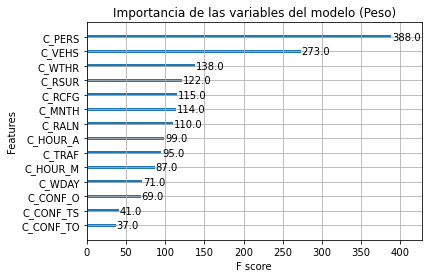

In [61]:
# Importancia por peso
xgb.plot_importance(model)
plt.title("Importancia de las variables del modelo (Peso)")
plt.show()

En el gráfico superior, se muestra la importancia de las variables según su peso (weight). De acuerdo con este gráfico, **```C_PERS```** es la variable que más se utiliza para dividir datos, seguida por **```C_VEHS```** y **```C_WTHR```**.

#### 6.3.3.2 Cover

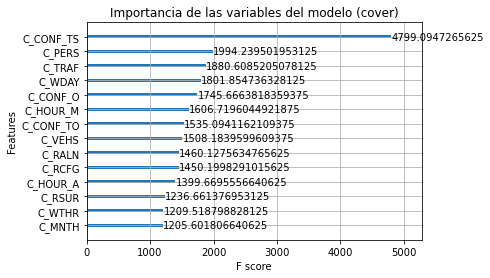

In [63]:
# Importancia por cover
xgb.plot_importance(model, importance_type="cover")
plt.title('Importancia de las variables del modelo (cover)')
plt.show()

En el gráfico superior, se muestra la importancia de las variables de acuerdo con el criterio cover. De acuerdo con este gráfico, **```C_CONF_TS```** es la variable que más se utiliza para dividir datos (ponderada por el número de observaciones que pasan por esos splits), seguida por **```C_PERS```** y **```C_TRAF```**.

#### 6.3.3.3 Ganancia (Gain)

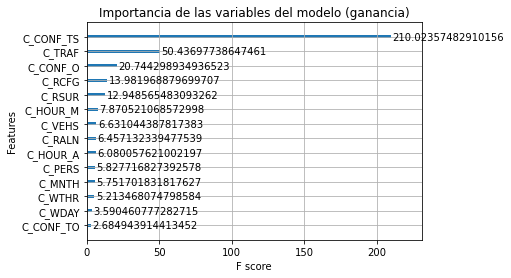

In [64]:
# Importancia por ganancia
xgb.plot_importance(model, importance_type="gain")
plt.title('Importancia de las variables del modelo (ganancia)')
plt.show()

En el gráfico superior, se muestra la importancia de las variables de acuerdo con el criterio de ganancia (gain). De acuerdo con este gráfico, **```C_CONF_TS```** es la variable que mayor ganancia aporta al modelo, seguida por **```C_TRAF```** y **```C_CONF_O```**.

### 6.3.4 SHAP: Explicación de predicciones

A continuación, procedemos a calcular los SHAP values para estimar el modelo de interpretabilidad

In [56]:
# Creamos el objeto 'explicador'
explainer = shap.TreeExplainer(model, X_train)

In [57]:
# Obtenemos los shap values de test
SHAP_values = explainer.shap_values(X_test)

100%|===================| 358016/358088 [16:56<00:00]        

Analizamos la primera predicción:

In [59]:
# Obtenemos los detalles que explican la primera predicción
shap.force_plot(explainer.expected_value, SHAP_values[0,:], X_test.iloc[0,:])

Esta gráfica muestra la influencia de cada variable a la hora de determinar si en concreto este accidente del dataset tiene o no fallecidos. 

En este caso, es un accidente ocurrido por la mañana (```C_HOUR_M```= 1), de un lunes (```C_WDAY```= 1) sin señales de tráfico (```C_TRAF```= 0), siendo una colisión de dos vehículos (```C_VEHS```= 2), en sentido opuesto (```C_CONF_TO```= 1), en una carretera sin curvas (```C_RALN```= 1) y sin ningún tipo de intersección (```C_RCFG```= 1).

De acuerdo con la tipología del accidente, SHAP especifica un aumento o disminución de la probabilidad de fallecidos en un accidente, en función de los valores que tomen las variables explicativas, siempre partiendo de un valor base que es ```0.1157```. En este caso, la probabilidad de que este accidente haya sido mortal es enorme, pues la configuración de variables en este caso concreto indica, con una enorme probabilidad, que al menos habrá algún fallecido.

A continuación, vamos a mostrar qué sucedió realmente en este accidente:

In [15]:
Y_test.loc[0]

1

El valor es 1, lo que indica que en este accidente no hubo fallecidos, por lo que en este caso concreto, el modelo habría errado en su predicción.

Visualizamos muchas predicciones:

In [65]:
# Graficamos todas las predicciones
shap.force_plot(explainer.expected_value, shap_values[:100,:], features=X_test.iloc[:100, :])

Este gráfico muestra muchas más observaciones del dataset, y se puede observar qué sucede en cada una situando el cursor sobre el accidente en cuestión. También se puede cambiar la información de los ejes, para observar las variables con un mayor detalle. 

### 6.3.5 SHAP: Importancia de variables
Gráfico de barras con la importancia media de cada variable. Estos gráficos vienen a representar la misma información que los gráficos de ```plot_importance```, si bien con una mayor consistencia, pues el método de estimación es SHAP. 

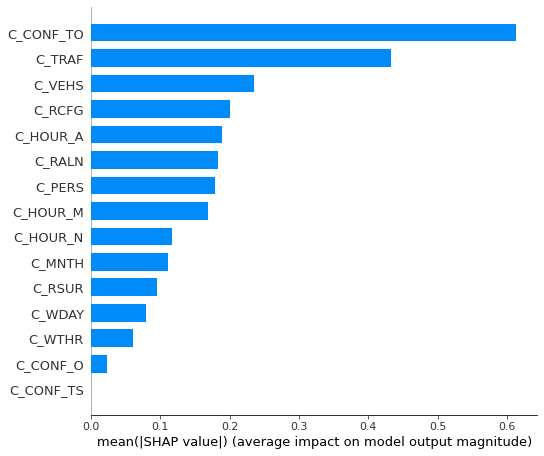

In [67]:
# Importancia según SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")

Vemos que, de acuerdo con SHAP, la variable más importante es ```C_CONF_TO```(colisión de varios vehículos en sentido opuesto), seguida de ```C_TRAF``` (existencia de señales de tráfico en el lugar del accidente) y ```C_VEHS``` (número de vehículos involucrados en el siniestro). 

### 6.3.6 SHAP: Summary Plot

Por último, procedemos a mostrar el que probablemente sea el gráfico más relevante de todos, pues muestra la importancia de cada variable, así como su poder discriminatorio, para ser capaz de separar las distintas clases.

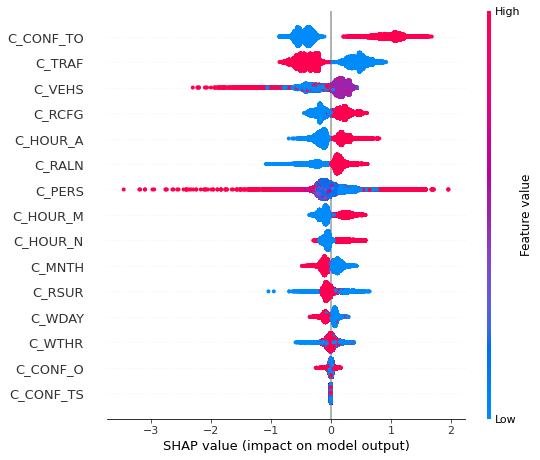

In [68]:
# Importancia de variables para tomar una decisión
shap.summary_plot(shap_values, X_test)

Los resultados siguen siendo consistentes con los gráficos anteriores, ya que ```C_CONF_TO```, ```C_TRAF``` y ```C_VEHS``` continúan siendo las variables más importantes. 

Este gráfico relaciona si el valor que toma una variable es, en primer lugar, alto o bajo, y en segundo lugar, cómo afecta que ese valor sea alto o bajo a la hora de determinar si hay un fallecido o no. Esto se entenderá mejor con los siguientes ejemplos empíricos, basándonos en los resultados del modelo:

* Cuando la variable ```C_CONF_TO``` toma valores **altos** (es decir, cuando el accidente es de dos vehículos en sentido opuesto), la probabilidad de que el accidente sea mortal, aumenta de una manera destacada. 
* Cuando la variable ```C_TRAF``` toma valores **bajos** (es decir, hay menos señales de tráfico en las carreteras), la probabilidad de que el accidente sea mortal aumenta. 

Cabe destacar también que ```C_RCFG``` (configuración de la cerretera),  ```C_HOUR_A``` (accidentes sucedidos por la tarde) y ```C_RALN``` (alineación de la carretera) son también variables que ayudan enormemente a la hora de determinar la siniestralidad en un accidente.

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 